In [11]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

In [12]:
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

In [13]:
tokens = ['0','1','2', '3','4','5','6','7','8','9','(',')', '+', '-', '*', 'N']

In [4]:
gen = image.ImageDataGenerator()

In [5]:
batches = gen.flow_from_directory(path+'/image_contest_level_1', 
                                  batch_size=1, 
                                  target_size=(30,90),
                                  shuffle=False,
                                  class_mode=None,
                                  color_mode='grayscale'
                                 )

Found 100000 images belonging to 1 classes.


In [6]:
import collections
test_batches = gen.flow_from_directory(path+'/test', 
                                  batch_size=1, 
                                  target_size=(30,90),
                                  shuffle=False,
                                  class_mode=None,
                                  color_mode='grayscale'
                                 )
seq2img = dict()
for i in range(test_batches.nb_sample):
    img = test_batches.next()[0]
    no = test_batches.filenames[i][8:][:-4]
    seq2img[int(no)]=img
test_imgs = []
od = collections.OrderedDict(sorted(seq2img.items()))
test_imgs = np.array([v for k,v in od.iteritems()])

Found 200000 images belonging to 1 classes.


KeyboardInterrupt: 

In [28]:
save_array(path+'test_imgs.dat', test_imgs)

In [3]:
test_imgs = load_array(path+'test_imgs.dat')

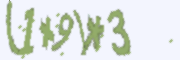

In [8]:
Image.open(path+'/test/unknown/199999.png')  ##17141

In [4]:
imgs = np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [6]:
save_array(path+'imgs0.dat', imgs)

In [5]:
imgs = load_array(path+'imgs0.dat')

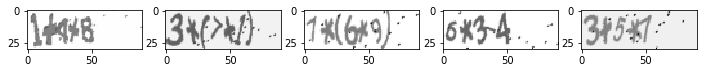

In [6]:
plots(imgs[:5].reshape((-1,30,90)))

In [7]:
x2label_idx = [int(f[8:][:-4]) for f in batches.filenames]

In [8]:
x2label_idx[:10]

[81314, 42703, 94273, 72552, 17141, 50750, 48773, 94926, 47470, 13306]

In [9]:
label_texts = []
lines = []
with open(path+'labels.txt') as f:
    lines = f.readlines()
label_texts = [l.strip().split()[0].ljust(7, 'N') for l in lines]

In [10]:
label_texts[:10]

['(4*8)+8',
 '7+3*0NN',
 '5+(5+2)',
 '(8-0)-8',
 '0+(0+2)',
 '(2*5)+0',
 '0+(1+8)',
 '2+(4+9)',
 '7*2+4NN',
 '0-(7*1)']

In [13]:
token2idx={char:i for i, char in enumerate(tokens)}

In [14]:
labels = np.array([[token2idx[token] for token in ts] for ts in label_texts])

In [15]:
labels.shape

(100000, 7)

In [17]:
idxs = np.random.permutation(imgs.shape[0])
mask = np.random.rand(len(imgs)) < 0.8
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]

In [18]:
len(trn_idxs), len(val_idxs)

(79931, 20069)

In [19]:
x_trn = imgs[trn_idxs]
y_trn_m = labels[np.array(x2label_idx)[trn_idxs]]

y_trn = np.expand_dims(np.stack(y_trn_m, axis=0), -1)

In [20]:
x_trn.shape, y_trn.shape

((79931, 1, 30, 90), (79931, 7, 1))

In [21]:
y_trn.shape

(79931, 7, 1)

In [22]:
x_val = imgs[val_idxs]
y_val_m = labels[np.array(x2label_idx)[val_idxs]]
y_val = np.expand_dims(np.stack(y_val_m, axis=0), -1)

In [23]:
x_val.shape, y_val.shape

((20069, 1, 30, 90), (20069, 7, 1))

In [24]:
mean_px = x_trn.mean().astype(np.float32)
std_px = x_trn.std().astype(np.float32)

In [25]:
def norm_input(x): return (x-mean_px)/std_px

# Batchnorm

In [26]:
def get_model():
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(1,30,90)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),

            Flatten(),
            BatchNormalization(),

            
            Dense(70, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),

            Dense(70, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
        
            Reshape((7, 10)),
            TimeDistributed(Dense(16, activation='softmax'))
        ])
    model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [450]:
def fit_model():
    model = get_model()
    model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, validation_data=(x_val, y_val))
    da = image.ImageDataGenerator(rotation_range=8,height_shift_range=0.05, zoom_range=0.08)
    trn_batches = da.flow(x_trn, y_trn, batch_size=64, shuffle=True)
    model.optimizer.lr=0.1
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))
    model.optimizer.lr=0.01
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))
    model.optimizer.lr=0.001
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))
    return model

In [451]:
models = [fit_model() for i in range(6)]

Train on 80112 samples, validate on 19888 samples
Epoch 1/1
80112/80112 [==============================] - 91s - loss: 1.0009 - acc: 0.6675 - val_loss: 0.1573 - val_acc: 0.9820
Epoch 1/1
80112/80112 [==============================] - 93s - loss: 0.5065 - acc: 0.8212 - val_loss: 0.0472 - val_acc: 0.9963
Epoch 1/1
80112/80112 [==============================] - 92s - loss: 0.3493 - acc: 0.8736 - val_loss: 0.0234 - val_acc: 0.9976
Epoch 1/1
80112/80112 [==============================] - 92s - loss: 0.2929 - acc: 0.8926 - val_loss: 0.0128 - val_acc: 0.9983
Train on 80112 samples, validate on 19888 samples
Epoch 1/1
80112/80112 [==============================] - 92s - loss: 1.0018 - acc: 0.6553 - val_loss: 0.1856 - val_acc: 0.9677
Epoch 1/1
80112/80112 [==============================] - 94s - loss: 0.5167 - acc: 0.8071 - val_loss: 0.0744 - val_acc: 0.9912
Epoch 1/1
80112/80112 [==============================] - 93s - loss: 0.3666 - acc: 0.8642 - val_loss: 0.0380 - val_acc: 0.9955
Epoch 1/1
8

In [465]:
for i, m in enumerate(models):
    m.save_weights(path+'m'+str(i)+'.wgt')

In [53]:
model = Sequential([
    Lambda(norm_input, input_shape=(1,30,90), output_shape=(1,30,90)),
    Convolution2D(32,3,3, activation='relu'),
    BatchNormalization(axis=1),
    Convolution2D(32,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(70, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(70, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Reshape((7, 10)),
    TimeDistributed(Dense(16, activation='softmax'))
])

In [55]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 1, 30, 90)     0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 32, 28, 88)    320         lambda_6[0][0]                   
____________________________________________________________________________________________________
batchnormalization_36 (BatchNorm (None, 32, 28, 88)    128         convolution2d_21[0][0]           
____________________________________________________________________________________________________
convolution2d_22 (Convolution2D) (None, 32, 26, 86)    9248        batchnormalization_36[0][0]      
___________________________________________________________________________________________

In [47]:
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, validation_data=(x_val, y_val))
model.save_weights(path+'test.pkl')

Train on 79892 samples, validate on 20108 samples
Epoch 1/1
79892/79892 [==============================] - 91s - loss: 1.0296 - acc: 0.6656 - val_loss: 0.1479 - val_acc: 0.9771


In [48]:
model.load_weights(path+'test.pkl')
da = image.ImageDataGenerator(rotation_range=8,height_shift_range=0.05, zoom_range=0.08)
trn_batches = da.flow(x_trn, y_trn, batch_size=64, shuffle=True)

model.optimizer.lr=0.1
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79892/79892 [==============================] - 97s - loss: 0.5112 - acc: 0.8200 - val_loss: 0.0645 - val_acc: 0.9913


In [54]:
da = image.ImageDataGenerator()
trn_batches = da.flow(x_trn, y_trn, batch_size=64, shuffle=True)
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.load_weights(path+'test.pkl')
model.optimizer.lr=0.1
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79892/79892 [==============================] - 96s - loss: 0.9557 - acc: 0.6140 - val_loss: 0.7994 - val_acc: 0.7818


In [28]:
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, validation_data=(x_val, y_val))
da = image.ImageDataGenerator(rotation_range=8,height_shift_range=0.05, zoom_range=0.08)
#da = image.ImageDataGenerator()
trn_batches = da.flow(x_trn, y_trn, batch_size=64, shuffle=True)


model.optimizer.lr=0.1
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

model.optimizer.lr=0.01
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

model.optimizer.lr=0.001
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Train on 79892 samples, validate on 20108 samples
Epoch 1/1
79892/79892 [==============================] - 90s - loss: 1.0179 - acc: 0.6539 - val_loss: 0.1925 - val_acc: 0.9668
Epoch 1/1
79892/79892 [==============================] - 96s - loss: 0.3705 - acc: 0.8640 - val_loss: 0.0433 - val_acc: 0.9928
Epoch 1/1
79892/79892 [==============================] - 91s - loss: 0.2729 - acc: 0.8965 - val_loss: 0.0239 - val_acc: 0.9964
Epoch 1/1
79892/79892 [==============================] - 91s - loss: 0.2389 - acc: 0.9086 - val_loss: 0.0154 - val_acc: 0.9978


In [329]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, validation_data=(x_val, y_val))

Train on 80112 samples, validate on 19888 samples
Epoch 1/1
80112/80112 [==============================] - 90s - loss: 0.6116 - acc: 0.8283 - val_loss: 0.0529 - val_acc: 0.9904


In [330]:
model.optimizer.lr=0.1

In [62]:
da = image.ImageDataGenerator(rotation_range=8,
                               height_shift_range=0.05, zoom_range=0.08, channel_shift_range=10)
trn_batches = da.flow(x_trn, y_trn, batch_size=64, shuffle=False)

In [333]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80112/80112 [==============================] - 90s - loss: 0.1628 - acc: 0.9439 - val_loss: 0.0152 - val_acc: 0.9966


In [334]:
model.optimizer.lr=0.01

In [335]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80112/80112 [==============================] - 90s - loss: 0.1359 - acc: 0.9513 - val_loss: 0.0111 - val_acc: 0.9972


In [294]:
model.optimizer.lr=0.001

In [295]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80112/80112 [==============================] - 93s - loss: 0.0265 - acc: 0.9923 - val_loss: 0.0101 - val_acc: 0.9977


In [284]:
model.optimizer.lr=0.0001

In [285]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80112/80112 [==============================] - 91s - loss: 0.0193 - acc: 0.9947 - val_loss: 0.0068 - val_acc: 0.9985


In [184]:
model.save_weights(path+'norm3.wgt')

In [97]:
??image.ImageDataGenerator

In [38]:
actual = np.array(y_val.reshape((-1, 7)))

In [133]:
def inspect_models(models):
    for m in models:
        (p, w) = predict_all(m)
        statistic(p, w)

In [41]:
def statistic(preds, wrong):
    print(
    (len(preds)*7-len(wrong))/(len(preds)*7),
    (len(preds)-len(set(wrong)))/len(preds),
    len(wrong),
    len(set(wrong)), 
    list(set(wrong))[:10])

In [153]:
def plot_result(preds, idx):
    #print('pred:'+''.join([tokens[i] for i in preds[idx]])+' label:'+''.join([tokens[i] for i in actual[idx]]))
    plot(x_val[idx].reshape((30,90)))

In [45]:
def show_result(preds, idxs):
    for idx in idxs:
        print('pred:'+''.join([tokens[i] for i in preds[idx]])+' label:'+''.join([tokens[i] for i in actual[idx]]))

In [143]:
def predict_ensemble(models):
    all_preds = np.stack([m.predict(x_val, batch_size=256) for m in models])
    avg_preds = all_preds.mean(axis=0)
    preds = np.array([[np.argmax(i) for i in p] for p in avg_preds])
    close = np.isclose(preds, actual)
    wrong = np.where(np.invert(close))[0]
    statistic(preds,wrong)
    show_result(preds, list(set(wrong)))
    for i in range(len(set(wrong))): plot_result(preds, list(set(wrong))[i])

In [145]:
def predict_single(model):
    ps = model.predict(x_val, verbose=1)
    preds = np.array([[np.argmax(i) for i in p] for p in ps])
    close = np.isclose(preds, actual)
    wrong = np.where(np.invert(close))[0]
    statistic(preds,wrong)
    show_result(preds, list(set(wrong)))
    for i in range(len(set(wrong))): plot_result(preds, list(set(wrong))[i])

In [141]:
statistic(preds,wrong)
show_result(preds, list(set(wrong)))

0.999985763402 0.999900343814 2 2 [1692, 11294]
pred:(5-9)+8 label:(5-9)*8
pred:7+(4-0) label:7+(4-7)


pred:(5-9)+8 label:(5-9)*8
pred:7+(4-0) label:7+(4-7)


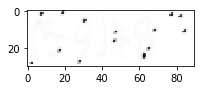

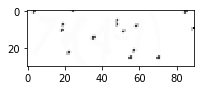

In [142]:
for i in range(len(set(wrong))): plot_result(preds, list(set(wrong))[i])

In [458]:
keras.metrics.sparse_categorical_accuracy(y_val, avg_preds).eval()

array(0.9993247985839844, dtype=float32)

pred:(3-4)-5 label:(3-4)-2
pred:(3-8)+2 label:(3-8)*2
pred:(1*5)+6 label:(1+5)+6
pred:1+(9+6) label:1+(9*6)
pred:(5+0)-6 label:(5+5)-6
pred:(5-1)+7 label:(5-1)*7
pred:8*(9*6) label:8*(9+6)
pred:(6-1)+3 label:(6-1)*3
pred:1-1+7NN label:1-1+6NN
pred:4-(4-5) label:4-(4*5)


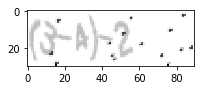

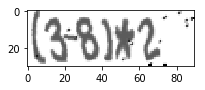

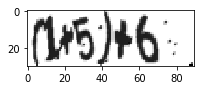

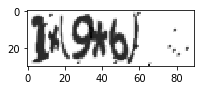

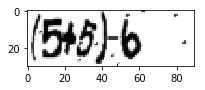

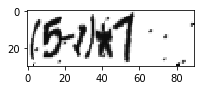

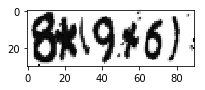

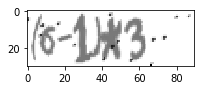

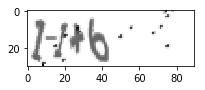

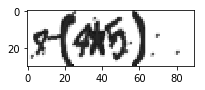

In [343]:
for x in list(set(wrong))[:10]:
    plot_result(x)

In [50]:
token2idx = { token:idx for idx,token in enumerate(tokens)}

[[ 5952     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0]
 [    0  6043     0     0     0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0  6144     0     0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0  5969     0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0  5974     0     0     0     0     0     0     0     0     0     0     0]
 [    0     1     0     0     0  6127     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0  6128     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     1     0  5870     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0  5928     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     1  6069     0     0     0     0     0     0]
 [    0   

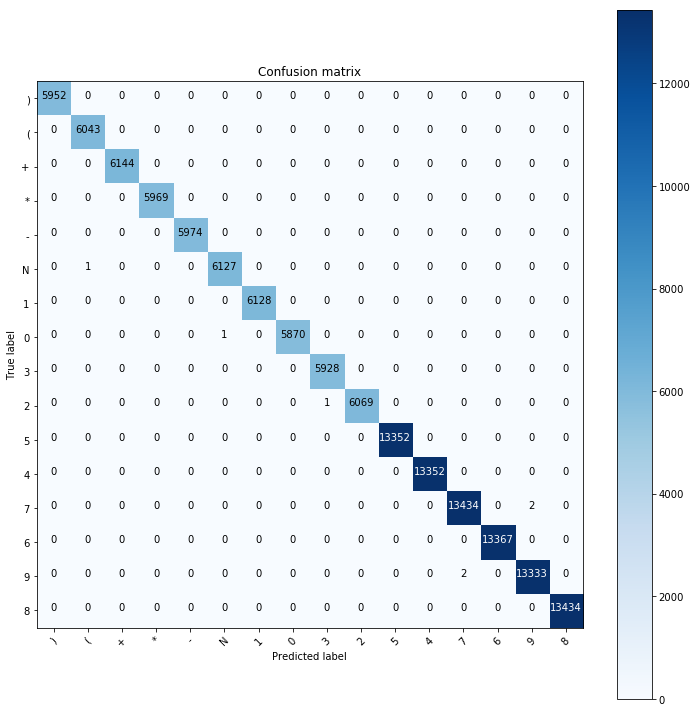

In [66]:
cm=confusion_matrix(np.concatenate(actual), np.concatenate(preds))
plot_confusion_matrix(cm, token2idx)

In [52]:
??confusion_matrix

In [119]:
model.optimizer.lr=0.01

In [81]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, validation_data=(x_val, y_val))

Train on 79860 samples, validate on 20140 samples
Epoch 1/1
79860/79860 [==============================] - 91s - loss: 0.0753 - acc: 0.9889 - val_loss: 0.2449 - val_acc: 0.9757


In [121]:
model.optimizer.lr=0.001

In [38]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 8038 samples, validate on 1962 samples
Epoch 1/4
8038/8038 [==============================] - 9s - loss: 0.0413 - acc: 0.9878 - val_loss: 1.5496 - val_acc: 0.8078
Epoch 2/4
8038/8038 [==============================] - 9s - loss: 0.0438 - acc: 0.9870 - val_loss: 0.1985 - val_acc: 0.9568
Epoch 3/4
8038/8038 [==============================] - 9s - loss: 0.0343 - acc: 0.9897 - val_loss: 0.2150 - val_acc: 0.9503
Epoch 4/4
8038/8038 [==============================] - 9s - loss: 0.0300 - acc: 0.9909 - val_loss: 0.5148 - val_acc: 0.9139


# dropout

In [169]:
model = Sequential([
    Lambda(norm_input, input_shape=(1,30,90)),
    #BatchNormalization(axis=1, input_shape=(1,30,90)),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Convolution2D(128,3,3, activation='relu'),
    BatchNormalization(axis=1),
    Convolution2D(128,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(140, activation='relu'),
    BatchNormalization(),
    Dropout(0),
    Reshape((7, 20)),
    TimeDistributed(Dense(16, activation='softmax'))
])

In [26]:
model.compile(Adam(lr=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 1, 30, 90)     0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 64, 28, 88)    640         lambda_3[0][0]                   
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 64, 28, 88)    256         convolution2d_9[0][0]            
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 64, 26, 86)    36928       batchnormalization_13[0][0]      
___________________________________________________________________________________________

In [ ]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, validation_data=(x_val, y_val))

Train on 80102 samples, validate on 19898 samples
Epoch 1/2
80102/80102 [==============================] - 204s - loss: 0.1966 - acc: 0.9313 - val_loss: 0.0641 - val_acc: 0.9851
Epoch 2/2
76160/80102 [===========================>..] - ETA: 9s - loss: 0.0469 - acc: 0.9888

In [35]:
model.optimizer.lr=0.01

In [30]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 79839 samples, validate on 20161 samples
Epoch 1/4
79839/79839 [==============================] - 89s - loss: 0.3963 - acc: 0.8363 - val_loss: 0.8403 - val_acc: 0.8315
Epoch 2/4
79839/79839 [==============================] - 89s - loss: 0.3875 - acc: 0.8404 - val_loss: 3.3851 - val_acc: 0.6475 1s - loss: 0.38
Epoch 3/4
79839/79839 [==============================] - 89s - loss: 0.3835 - acc: 0.8417 - val_loss: 6.5607 - val_acc: 0.4533
Epoch 4/4
79839/79839 [==============================] - 89s - loss: 0.3713 - acc: 0.8450 - val_loss: 2.1141 - val_acc: 0.8101


In [31]:
model.optimizer.lr=0.001
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 79839 samples, validate on 20161 samples
Epoch 1/4
79839/79839 [==============================] - 89s - loss: 0.3769 - acc: 0.8441 - val_loss: 2.9895 - val_acc: 0.6867
Epoch 2/4
79839/79839 [==============================] - 89s - loss: 0.3579 - acc: 0.8507 - val_loss: 3.0588 - val_acc: 0.6825
Epoch 3/4
79839/79839 [==============================] - 89s - loss: 0.3675 - acc: 0.8478 - val_loss: 5.7585 - val_acc: 0.5478
Epoch 4/4
79839/79839 [==============================] - 89s - loss: 0.3513 - acc: 0.8528 - val_loss: 2.4509 - val_acc: 0.6909


In [56]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 8038 samples, validate on 1962 samples
Epoch 1/4
8038/8038 [==============================] - 9s - loss: 0.5158 - acc: 0.7775 - val_loss: 0.1391 - val_acc: 0.9531
Epoch 2/4
8038/8038 [==============================] - 9s - loss: 0.5123 - acc: 0.7785 - val_loss: 0.1634 - val_acc: 0.9352
Epoch 3/4
8038/8038 [==============================] - 9s - loss: 0.5007 - acc: 0.7837 - val_loss: 0.1569 - val_acc: 0.9380
Epoch 4/4
8038/8038 [==============================] - 9s - loss: 0.4903 - acc: 0.7907 - val_loss: 0.1245 - val_acc: 0.9543


In [57]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 8038 samples, validate on 1962 samples
Epoch 1/4
8038/8038 [==============================] - 9s - loss: 0.4862 - acc: 0.7901 - val_loss: 0.2018 - val_acc: 0.9251
Epoch 2/4
8038/8038 [==============================] - 9s - loss: 0.4848 - acc: 0.7899 - val_loss: 0.1457 - val_acc: 0.9459
Epoch 3/4
8038/8038 [==============================] - 9s - loss: 0.4692 - acc: 0.8000 - val_loss: 0.2247 - val_acc: 0.9250
Epoch 4/4
8038/8038 [==============================] - 9s - loss: 0.4854 - acc: 0.7940 - val_loss: 0.1235 - val_acc: 0.9567


# experiment Data argumentation

In [26]:
model = Sequential([
    BatchNormalization(axis=1, input_shape=(1,30,90)),
    Convolution2D(32,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(140, activation='relu'),
    BatchNormalization(),
    Reshape((7, 20)),
    TimeDistributed(Dense(16, activation='softmax'))
])

In [27]:
def get_test_model():
    return Sequential([
            BatchNormalization(axis=1, input_shape=(1,30,90)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),
            Flatten(),
            BatchNormalization(),
            Dense(140, activation='relu'),
            BatchNormalization(),
            Reshape((7, 20)),
            TimeDistributed(Dense(16, activation='softmax'))
        ])

In [28]:
def trn_model(da):
    evals = []
    for _ in range(3):
        model=get_test_model()
        model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        trn_batches = da.flow(x_trn, y_trn, batch_size=64, shuffle=True)
        model.fit_generator(trn_batches, len(x_trn), nb_epoch=2, validation_data=(x_val, y_val))
        evals.append(model.evaluate(x_val, y_val, batch_size=256))
    print(np.array(evals).mean(axis=0))

In [29]:
da = image.ImageDataGenerator()
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 58s - loss: 0.2621 - acc: 0.9337 - val_loss: 0.0655 - val_acc: 0.9834
Epoch 2/2
80005/80005 [==============================] - 58s - loss: 0.2480 - acc: 0.9381 - val_loss: 0.0734 - val_acc: 0.9831
Epoch 2/2
80005/80005 [==============================] - 58s - loss: 0.2549 - acc: 0.9336 - val_loss: 0.0993 - val_acc: 0.9694
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0612  0.9811]


In [32]:
da = image.ImageDataGenerator()
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.2520 - acc: 0.9373 - val_loss: 0.1101 - val_acc: 0.9705
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2483 - acc: 0.9367 - val_loss: 0.0819 - val_acc: 0.9801
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2600 - acc: 0.9343 - val_loss: 0.0802 - val_acc: 0.9808
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0503  0.9849]


In [30]:
da = image.ImageDataGenerator(width_shift_range=0.05)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.3405 - acc: 0.9101 - val_loss: 0.1076 - val_acc: 0.9715
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3218 - acc: 0.9139 - val_loss: 0.0775 - val_acc: 0.9821
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3167 - acc: 0.9157 - val_loss: 0.0724 - val_acc: 0.9835
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0821  0.9751]


In [31]:
da = image.ImageDataGenerator(width_shift_range=0.03)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.2726 - acc: 0.9292 - val_loss: 0.0783 - val_acc: 0.9783
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2871 - acc: 0.9257 - val_loss: 0.0820 - val_acc: 0.9744
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2720 - acc: 0.9300 - val_loss: 0.0578 - val_acc: 0.9876
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.073   0.9762]


### height shift range

In [33]:
da = image.ImageDataGenerator(height_shift_range=0.04)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.2739 - acc: 0.9268 - val_loss: 0.0603 - val_acc: 0.9851
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2754 - acc: 0.9283 - val_loss: 0.0656 - val_acc: 0.9846
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2752 - acc: 0.9250 - val_loss: 0.0691 - val_acc: 0.9826
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0771  0.974 ]


In [34]:
da = image.ImageDataGenerator(height_shift_range=0.03)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.2727 - acc: 0.9291 - val_loss: 0.0764 - val_acc: 0.9794
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2858 - acc: 0.9256 - val_loss: 0.0770 - val_acc: 0.9793
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2781 - acc: 0.9278 - val_loss: 0.0668 - val_acc: 0.9836
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0367  0.9897]


### rotation range

In [35]:
da = image.ImageDataGenerator(rotation_range=15)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.4402 - acc: 0.8696 - val_loss: 0.1111 - val_acc: 0.9700
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.4368 - acc: 0.8699 - val_loss: 0.1541 - val_acc: 0.9570
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.4362 - acc: 0.8694 - val_loss: 0.1260 - val_acc: 0.9625
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0742  0.979 ]


In [36]:
da = image.ImageDataGenerator(rotation_range=10)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.3754 - acc: 0.8930 - val_loss: 0.1200 - val_acc: 0.9709
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3775 - acc: 0.8934 - val_loss: 0.0797 - val_acc: 0.9812
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3619 - acc: 0.8963 - val_loss: 0.0893 - val_acc: 0.9790
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0599  0.9829]


In [37]:
da = image.ImageDataGenerator(rotation_range=5)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.2981 - acc: 0.9191 - val_loss: 0.0703 - val_acc: 0.9827
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3053 - acc: 0.9182 - val_loss: 0.0794 - val_acc: 0.9813
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3071 - acc: 0.9178 - val_loss: 0.0841 - val_acc: 0.9787
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0573  0.9823]


In [38]:
da = image.ImageDataGenerator(rotation_range=8)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.3465 - acc: 0.9031 - val_loss: 0.0760 - val_acc: 0.9817
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3526 - acc: 0.9005 - val_loss: 0.1018 - val_acc: 0.9745
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3444 - acc: 0.9045 - val_loss: 0.1008 - val_acc: 0.9692
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0563  0.9837]


In [39]:
da = image.ImageDataGenerator(channel_shift_range=20)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.2783 - acc: 0.9291 - val_loss: 0.0982 - val_acc: 0.9736
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2624 - acc: 0.9335 - val_loss: 0.0590 - val_acc: 0.9862
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2759 - acc: 0.9291 - val_loss: 0.0794 - val_acc: 0.9817
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0328  0.9909]


In [40]:
da = image.ImageDataGenerator(channel_shift_range=10)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 58s - loss: 0.2640 - acc: 0.9331 - val_loss: 0.0529 - val_acc: 0.9879
Epoch 2/2
80005/80005 [==============================] - 58s - loss: 0.2515 - acc: 0.9356 - val_loss: 0.0750 - val_acc: 0.9827
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2552 - acc: 0.9352 - val_loss: 0.0720 - val_acc: 0.9796
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0348  0.9897]


In [41]:
da = image.ImageDataGenerator(channel_shift_range=30)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 58s - loss: 0.2976 - acc: 0.9251 - val_loss: 0.0751 - val_acc: 0.9819
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2875 - acc: 0.9272 - val_loss: 0.0679 - val_acc: 0.9839
Epoch 2/2
80005/80005 [==============================] - 58s - loss: 0.2840 - acc: 0.9277 - val_loss: 0.0837 - val_acc: 0.9786
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0338  0.9901]


In [42]:
da = image.ImageDataGenerator(shear_range=0.1)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.3043 - acc: 0.9183 - val_loss: 0.0744 - val_acc: 0.9812
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3161 - acc: 0.9159 - val_loss: 0.1022 - val_acc: 0.9728
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.3109 - acc: 0.9173 - val_loss: 0.0781 - val_acc: 0.9809
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0478  0.9861]


In [44]:
da = image.ImageDataGenerator(shear_range=0.05)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 58s - loss: 0.2746 - acc: 0.9294 - val_loss: 0.0935 - val_acc: 0.9740
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2684 - acc: 0.9301 - val_loss: 0.0680 - val_acc: 0.9835
Epoch 2/2
80005/80005 [==============================] - 58s - loss: 0.2691 - acc: 0.9309 - val_loss: 0.0692 - val_acc: 0.9827
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.041   0.9888]


In [45]:
da = image.ImageDataGenerator(shear_range=0.08)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.2989 - acc: 0.9204 - val_loss: 0.0785 - val_acc: 0.9791
Epoch 2/2
80005/80005 [==============================] - 59s - loss: 0.2949 - acc: 0.9213 - val_loss: 0.0655 - val_acc: 0.9834
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2894 - acc: 0.9234 - val_loss: 0.0686 - val_acc: 0.9841
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.1679  0.9599]


In [46]:
da = image.ImageDataGenerator(zoom_range=0.08)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 58s - loss: 0.2809 - acc: 0.9288 - val_loss: 0.0948 - val_acc: 0.9688
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2973 - acc: 0.9229 - val_loss: 0.0605 - val_acc: 0.9845
Epoch 2/2
80005/80005 [==============================] - 59s - loss: 0.2878 - acc: 0.9252 - val_loss: 0.0645 - val_acc: 0.9844
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0455  0.9866]


In [47]:
da = image.ImageDataGenerator(zoom_range=0.05)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 57s - loss: 0.2834 - acc: 0.9269 - val_loss: 0.0786 - val_acc: 0.9800
Epoch 2/2
80005/80005 [==============================] - 59s - loss: 0.2843 - acc: 0.9258 - val_loss: 0.0617 - val_acc: 0.9853
Epoch 2/2
80005/80005 [==============================] - 57s - loss: 0.2762 - acc: 0.9292 - val_loss: 0.0578 - val_acc: 0.9865
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0374  0.9898]


In [48]:
da = image.ImageDataGenerator(zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03)
trn_model(da)

Epoch 1/2
80005/80005 [==============================] - 59s - loss: 0.4376 - acc: 0.8715 - val_loss: 0.0776 - val_acc: 0.9790
Epoch 2/2
80005/80005 [==============================] - 58s - loss: 0.4363 - acc: 0.8717 - val_loss: 0.0809 - val_acc: 0.9822
Epoch 2/2
80005/80005 [==============================] - 59s - loss: 0.4360 - acc: 0.8717 - val_loss: 0.1294 - val_acc: 0.9677
Epoch 2/2
19712/19995 [============================>.] - ETA: 0s[ 0.0457  0.9857]


In [49]:
model=get_test_model()
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
trn_batches = da.flow(x_trn, y_trn, batch_size=64, shuffle=True)
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80005/80005 [==============================] - 58s - loss: 0.4360 - acc: 0.8730 - val_loss: 0.0973 - val_acc: 0.9779


In [50]:
model.optimizer.lr=0.1

In [51]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80005/80005 [==============================] - 46s - loss: 0.1093 - acc: 0.9658 - val_loss: 0.1236 - val_acc: 0.9582


In [52]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80005/80005 [==============================] - 46s - loss: 0.0775 - acc: 0.9758 - val_loss: 0.0876 - val_acc: 0.9723


In [53]:
model.optimizer.lr=0.001

In [54]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80005/80005 [==============================] - 46s - loss: 0.0597 - acc: 0.9810 - val_loss: 0.0285 - val_acc: 0.9908


In [55]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80005/80005 [==============================] - 46s - loss: 0.0534 - acc: 0.9830 - val_loss: 0.0434 - val_acc: 0.9864


In [56]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
80005/80005 [==============================] - 46s - loss: 0.0480 - acc: 0.9848 - val_loss: 0.0202 - val_acc: 0.9936


In [57]:
model.optimizer.lr=0.0001

In [58]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=5, validation_data=(x_val, y_val))

Epoch 1/5
80005/80005 [==============================] - 46s - loss: 0.0434 - acc: 0.9862 - val_loss: 0.0351 - val_acc: 0.9881
Epoch 2/5
80005/80005 [==============================] - 46s - loss: 0.0394 - acc: 0.9874 - val_loss: 0.0166 - val_acc: 0.9949
Epoch 3/5
80005/80005 [==============================] - 46s - loss: 0.0389 - acc: 0.9875 - val_loss: 0.0125 - val_acc: 0.9964
Epoch 4/5
80005/80005 [==============================] - 46s - loss: 0.0347 - acc: 0.9888 - val_loss: 0.0175 - val_acc: 0.9946
Epoch 5/5
80005/80005 [==============================] - 46s - loss: 0.0341 - acc: 0.9891 - val_loss: 0.0309 - val_acc: 0.9900


In [59]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=5, validation_data=(x_val, y_val))

Epoch 1/5
80005/80005 [==============================] - 46s - loss: 0.0330 - acc: 0.9894 - val_loss: 0.0189 - val_acc: 0.9936
Epoch 2/5
80005/80005 [==============================] - 46s - loss: 0.0325 - acc: 0.9896 - val_loss: 0.0136 - val_acc: 0.9956
Epoch 3/5
80005/80005 [==============================] - 46s - loss: 0.0300 - acc: 0.9903 - val_loss: 0.0137 - val_acc: 0.9957
Epoch 4/5
80005/80005 [==============================] - 46s - loss: 0.0287 - acc: 0.9906 - val_loss: 0.0092 - val_acc: 0.9972
Epoch 5/5
80005/80005 [==============================] - 46s - loss: 0.0272 - acc: 0.9912 - val_loss: 0.0233 - val_acc: 0.9927


In [60]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=5, validation_data=(x_val, y_val))

Epoch 1/5
80005/80005 [==============================] - 46s - loss: 0.0279 - acc: 0.9910 - val_loss: 0.0135 - val_acc: 0.9954
Epoch 2/5
80005/80005 [==============================] - 46s - loss: 0.0274 - acc: 0.9913 - val_loss: 0.0089 - val_acc: 0.9971
Epoch 3/5
80005/80005 [==============================] - 46s - loss: 0.0268 - acc: 0.9913 - val_loss: 0.0120 - val_acc: 0.9961
Epoch 4/5
80005/80005 [==============================] - 46s - loss: 0.0252 - acc: 0.9917 - val_loss: 0.0110 - val_acc: 0.9965
Epoch 5/5
80005/80005 [==============================] - 46s - loss: 0.0246 - acc: 0.9920 - val_loss: 0.0144 - val_acc: 0.9950


In [61]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
80005/80005 [==============================] - 46s - loss: 0.0245 - acc: 0.9923 - val_loss: 0.0132 - val_acc: 0.9955
Epoch 2/10
80005/80005 [==============================] - 46s - loss: 0.0233 - acc: 0.9925 - val_loss: 0.0135 - val_acc: 0.9955
Epoch 3/10
80005/80005 [==============================] - 46s - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0217 - val_acc: 0.9925
Epoch 4/10
80005/80005 [==============================] - 46s - loss: 0.0227 - acc: 0.9926 - val_loss: 0.0305 - val_acc: 0.9889
Epoch 5/10
80005/80005 [==============================] - 46s - loss: 0.0221 - acc: 0.9929 - val_loss: 0.0120 - val_acc: 0.9961
Epoch 6/10
80005/80005 [==============================] - 46s - loss: 0.0210 - acc: 0.9932 - val_loss: 0.0110 - val_acc: 0.9962
Epoch 7/10
80005/80005 [==============================] - 46s - loss: 0.0206 - acc: 0.9933 - val_loss: 0.0219 - val_acc: 0.9928
Epoch 8/10
80005/80005 [==============================] - 46s - loss: 0.0202 - acc: 0.9935 - val_loss: 0

In [62]:
model.optimizer.lr=0.00001

In [63]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
80005/80005 [==============================] - 46s - loss: 0.0206 - acc: 0.9933 - val_loss: 0.0079 - val_acc: 0.9976
Epoch 2/10
80005/80005 [==============================] - 46s - loss: 0.0182 - acc: 0.9941 - val_loss: 0.0095 - val_acc: 0.9970
Epoch 3/10
80005/80005 [==============================] - 46s - loss: 0.0209 - acc: 0.9932 - val_loss: 0.0303 - val_acc: 0.9917
Epoch 4/10
80005/80005 [==============================] - 46s - loss: 0.0214 - acc: 0.9931 - val_loss: 0.0094 - val_acc: 0.9970
Epoch 5/10
80005/80005 [==============================] - 46s - loss: 0.0206 - acc: 0.9935 - val_loss: 0.0135 - val_acc: 0.9957
Epoch 6/10
80005/80005 [==============================] - 46s - loss: 0.0202 - acc: 0.9934 - val_loss: 0.0073 - val_acc: 0.9977
Epoch 7/10
80005/80005 [==============================] - 46s - loss: 0.0190 - acc: 0.9940 - val_loss: 0.0058 - val_acc: 0.9981
Epoch 8/10
80005/80005 [==============================] - 46s - loss: 0.0169 - acc: 0.9946 - val_loss: 0

In [64]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
80005/80005 [==============================] - 46s - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0088 - val_acc: 0.9971
Epoch 2/10
80005/80005 [==============================] - 46s - loss: 0.0175 - acc: 0.9943 - val_loss: 0.0079 - val_acc: 0.9975
Epoch 3/10
80005/80005 [==============================] - 46s - loss: 0.0165 - acc: 0.9946 - val_loss: 0.0068 - val_acc: 0.9981
Epoch 4/10
80005/80005 [==============================] - 46s - loss: 0.0174 - acc: 0.9944 - val_loss: 0.0151 - val_acc: 0.9948
Epoch 5/10
80005/80005 [==============================] - 46s - loss: 0.0170 - acc: 0.9944 - val_loss: 0.0054 - val_acc: 0.9982
Epoch 6/10
80005/80005 [==============================] - 46s - loss: 0.0189 - acc: 0.9938 - val_loss: 0.0157 - val_acc: 0.9953
Epoch 7/10
80005/80005 [==============================] - 46s - loss: 0.0192 - acc: 0.9937 - val_loss: 0.0100 - val_acc: 0.9967
Epoch 8/10
80005/80005 [==============================] - 46s - loss: 0.0171 - acc: 0.9944 - val_loss: 0

In [77]:
model.optimizer.lr=0.0001

In [78]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
80005/80005 [==============================] - 46s - loss: 0.0164 - acc: 0.9946 - val_loss: 0.0069 - val_acc: 0.9978
Epoch 2/10
80005/80005 [==============================] - 46s - loss: 0.0186 - acc: 0.9941 - val_loss: 0.0093 - val_acc: 0.9970
Epoch 3/10
80005/80005 [==============================] - 46s - loss: 0.0170 - acc: 0.9945 - val_loss: 0.0098 - val_acc: 0.9968
Epoch 4/10
80005/80005 [==============================] - 46s - loss: 0.0160 - acc: 0.9948 - val_loss: 0.0047 - val_acc: 0.9985
Epoch 5/10
80005/80005 [==============================] - 46s - loss: 0.0155 - acc: 0.9950 - val_loss: 0.0101 - val_acc: 0.9966
Epoch 6/10
80005/80005 [==============================] - 46s - loss: 0.0154 - acc: 0.9949 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 7/10
80005/80005 [==============================] - 46s - loss: 0.0161 - acc: 0.9948 - val_loss: 0.0084 - val_acc: 0.9971
Epoch 8/10
80005/80005 [==============================] - 46s - loss: 0.0155 - acc: 0.9950 - val_loss: 0

In [52]:
def get_model():
    return Sequential([
            BatchNormalization(axis=1, input_shape=(1,30,90)),
            #Lambda(norm_input, input_shape=(1,30,90), output_shape=(1,30,90)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),

            Flatten(),
            BatchNormalization(),

            
            Dense(70, activation='relu'),
            BatchNormalization(),

            Dense(70, activation='relu'),
            BatchNormalization(),
        
            Reshape((7, 10)),
            TimeDistributed(Dense(16, activation='softmax'))
        ])


In [28]:
model = Sequential([
            BatchNormalization(axis=1, input_shape=(1,30,90)),
            #Lambda(norm_input, input_shape=(1,30,90), output_shape=(1,30,90)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),

            Flatten(),
            BatchNormalization(),

            
            Dense(70, activation='relu'),
            BatchNormalization(),

            Dense(70, activation='relu'),
            BatchNormalization(),
        
            Reshape((7, 10)),
            TimeDistributed(Dense(16, activation='softmax'))
        ])
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
da = image.ImageDataGenerator(zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03)
trn_batches = da.flow(x_trn, y_trn, batch_size=64, shuffle=True)

In [30]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79931/79931 [==============================] - 96s - loss: 0.6516 - acc: 0.8142 - val_loss: 0.0400 - val_acc: 0.9939


In [31]:
model.optimizer.lr=0.1

In [32]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=4, validation_data=(x_val, y_val))

Epoch 1/4
79931/79931 [==============================] - 96s - loss: 0.0668 - acc: 0.9832 - val_loss: 0.0106 - val_acc: 0.9979
Epoch 2/4
79931/79931 [==============================] - 96s - loss: 0.0424 - acc: 0.9883 - val_loss: 0.0067 - val_acc: 0.9986
Epoch 3/4
79931/79931 [==============================] - 96s - loss: 0.0302 - acc: 0.9916 - val_loss: 0.0074 - val_acc: 0.9981
Epoch 4/4
79931/79931 [==============================] - 95s - loss: 0.0252 - acc: 0.9928 - val_loss: 0.0041 - val_acc: 0.9989


In [33]:
model.optimizer.lr=0.01

In [34]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
79931/79931 [==============================] - 96s - loss: 0.0201 - acc: 0.9942 - val_loss: 0.0059 - val_acc: 0.9984
Epoch 2/10
79931/79931 [==============================] - 96s - loss: 0.0207 - acc: 0.9941 - val_loss: 0.0025 - val_acc: 0.9994
Epoch 3/10
79931/79931 [==============================] - 96s - loss: 0.0165 - acc: 0.9953 - val_loss: 0.0030 - val_acc: 0.9993
Epoch 4/10
79931/79931 [==============================] - 96s - loss: 0.0143 - acc: 0.9959 - val_loss: 0.0031 - val_acc: 0.9992
Epoch 5/10
79931/79931 [==============================] - 96s - loss: 0.0144 - acc: 0.9958 - val_loss: 0.0017 - val_acc: 0.9996
Epoch 6/10
79931/79931 [==============================] - 97s - loss: 0.0119 - acc: 0.9966 - val_loss: 0.0013 - val_acc: 0.9997
Epoch 7/10
79931/79931 [==============================] - 97s - loss: 0.0131 - acc: 0.9963 - val_loss: 0.0010 - val_acc: 0.9998
Epoch 8/10
79931/79931 [==============================] - 98s - loss: 0.0112 - acc: 0.9968 - val_loss: 0

In [35]:
model.optimizer.lr=0.001

In [36]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
79931/79931 [==============================] - 97s - loss: 0.0094 - acc: 0.9973 - val_loss: 0.0010 - val_acc: 0.9997
Epoch 2/10
79931/79931 [==============================] - 98s - loss: 0.0088 - acc: 0.9975 - val_loss: 0.0026 - val_acc: 0.9992
Epoch 3/10
79931/79931 [==============================] - 98s - loss: 0.0090 - acc: 0.9975 - val_loss: 0.0010 - val_acc: 0.9997
Epoch 4/10
79931/79931 [==============================] - 98s - loss: 0.0083 - acc: 0.9976 - val_loss: 0.0021 - val_acc: 0.9993
Epoch 5/10
79931/79931 [==============================] - 98s - loss: 0.0092 - acc: 0.9974 - val_loss: 0.0013 - val_acc: 0.9997
Epoch 6/10
79931/79931 [==============================] - 98s - loss: 0.0081 - acc: 0.9977 - val_loss: 0.0012 - val_acc: 0.9997
Epoch 7/10
79931/79931 [==============================] - 98s - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0012 - val_acc: 0.9996
Epoch 8/10
79931/79931 [==============================] - 98s - loss: 0.0081 - acc: 0.9977 - val_loss: 6

In [53]:
def fit_model():
    model = get_model()
    model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))
    
    model.optimizer.lr=0.1
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=4, validation_data=(x_val, y_val))
    
    model.optimizer.lr=0.01
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))
    
    model.optimizer.lr=0.001
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))
    return model

In [55]:
models = [fit_model() for i in range(6)]

Epoch 1/1
79931/79931 [==============================] - 94s - loss: 0.6302 - acc: 0.8168 - val_loss: 0.0349 - val_acc: 0.9950
Epoch 1/4
79931/79931 [==============================] - 94s - loss: 0.0665 - acc: 0.9836 - val_loss: 0.0287 - val_acc: 0.9933
Epoch 2/4
79931/79931 [==============================] - 94s - loss: 0.0375 - acc: 0.9898 - val_loss: 0.0166 - val_acc: 0.9950
Epoch 3/4
79931/79931 [==============================] - 94s - loss: 0.0271 - acc: 0.9926 - val_loss: 0.0049 - val_acc: 0.9988
Epoch 4/4
79931/79931 [==============================] - 95s - loss: 0.0246 - acc: 0.9930 - val_loss: 0.0060 - val_acc: 0.9984
Epoch 1/10
79931/79931 [==============================] - 95s - loss: 0.0183 - acc: 0.9949 - val_loss: 0.0030 - val_acc: 0.9993
Epoch 2/10
79931/79931 [==============================] - 95s - loss: 0.0174 - acc: 0.9951 - val_loss: 0.0032 - val_acc: 0.9992
Epoch 3/10
79931/79931 [==============================] - 95s - loss: 0.0157 - acc: 0.9956 - val_loss: 0.0045

79931/79931 [==============================] - 98s - loss: 0.0110 - acc: 0.9969 - val_loss: 0.0013 - val_acc: 0.9996
Epoch 10/10
79931/79931 [==============================] - 98s - loss: 0.0094 - acc: 0.9974 - val_loss: 0.0014 - val_acc: 0.9996
Epoch 1/10
79931/79931 [==============================] - 97s - loss: 0.0102 - acc: 0.9972 - val_loss: 0.0014 - val_acc: 0.9996
Epoch 2/10
79931/79931 [==============================] - 98s - loss: 0.0089 - acc: 0.9975 - val_loss: 0.0030 - val_acc: 0.9991
Epoch 3/10
79931/79931 [==============================] - 98s - loss: 0.0069 - acc: 0.9980 - val_loss: 0.0014 - val_acc: 0.9996
Epoch 4/10
79931/79931 [==============================] - 98s - loss: 0.0089 - acc: 0.9975 - val_loss: 0.0013 - val_acc: 0.9997
Epoch 5/10
79931/79931 [==============================] - 98s - loss: 0.0083 - acc: 0.9977 - val_loss: 0.0014 - val_acc: 0.9997
Epoch 6/10
79931/79931 [==============================] - 98s - loss: 0.0070 - acc: 0.9980 - val_loss: 7.5386e-04 

79931/79931 [==============================] - 99s - loss: 0.0696 - acc: 0.9826 - val_loss: 0.0145 - val_acc: 0.9969
Epoch 2/4
79931/79931 [==============================] - 99s - loss: 0.0371 - acc: 0.9901 - val_loss: 0.0106 - val_acc: 0.9975
Epoch 3/4
79931/79931 [==============================] - 99s - loss: 0.0285 - acc: 0.9921 - val_loss: 0.0052 - val_acc: 0.9988
Epoch 4/4
79931/79931 [==============================] - 100s - loss: 0.0256 - acc: 0.9929 - val_loss: 0.0035 - val_acc: 0.9991
Epoch 1/10
79931/79931 [==============================] - 99s - loss: 0.0209 - acc: 0.9939 - val_loss: 0.0067 - val_acc: 0.9982
Epoch 2/10
79931/79931 [==============================] - 99s - loss: 0.0173 - acc: 0.9950 - val_loss: 0.0054 - val_acc: 0.9984
Epoch 3/10
79931/79931 [==============================] - 99s - loss: 0.0175 - acc: 0.9950 - val_loss: 0.0029 - val_acc: 0.9993
Epoch 4/10
79931/79931 [==============================] - 99s - loss: 0.0143 - acc: 0.9958 - val_loss: 0.0023 - val_a

In [56]:
for i, m in enumerate(models):
    m.save_weights(path+'mf'+str(i)+'.wgt')

In [112]:
all_preds = np.stack([m.predict(x_val, batch_size=256) for m in models])

In [113]:
avg_preds = all_preds.mean(axis=0)

preds = np.array([[np.argmax(i) for i in p] for p in avg_preds])
close = np.isclose(preds, actual)
wrong = np.where(np.invert(close))[0]

In [65]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_9 (BatchNorma (None, 1, 30, 90)     4           batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 32, 28, 88)    320         batchnormalization_9[0][0]       
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorm (None, 32, 28, 88)    128         convolution2d_5[0][0]            
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 32, 26, 86)    9248        batchnormalization_10[0][0]      
___________________________________________________________________________________________

In [79]:
model = Sequential([
            BatchNormalization(axis=1, input_shape=(1,30,90)),
            #Lambda(norm_input, input_shape=(1,30,90), output_shape=(1,30,90)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),

            Flatten(),
            BatchNormalization(),

            
            Dense(70, activation='relu'),
            BatchNormalization(),

            Dense(70, activation='relu'),
            BatchNormalization(),
        
            Reshape((7, 10)),
            TimeDistributed(Dense(16, activation='softmax'))
        ])
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [68]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_65 (BatchNorm (None, 1, 30, 90)     4           batchnormalization_input_9[0][0] 
____________________________________________________________________________________________________
convolution2d_33 (Convolution2D) (None, 32, 28, 88)    320         batchnormalization_65[0][0]      
____________________________________________________________________________________________________
batchnormalization_66 (BatchNorm (None, 32, 28, 88)    128         convolution2d_33[0][0]           
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 32, 26, 86)    9248        batchnormalization_66[0][0]      
___________________________________________________________________________________________

In [80]:
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

model.optimizer.lr=0.1
model.fit_generator(trn_batches, len(x_trn), nb_epoch=4, validation_data=(x_val, y_val))

model.optimizer.lr=0.01
model.fit_generator(trn_batches, len(x_trn), nb_epoch=12, validation_data=(x_val, y_val))

model.optimizer.lr=0.001
model.fit_generator(trn_batches, len(x_trn), nb_epoch=20, validation_data=(x_val, y_val))

Epoch 1/1
79931/79931 [==============================] - 95s - loss: 0.6335 - acc: 0.8265 - val_loss: 0.0653 - val_acc: 0.9875
Epoch 1/4
79931/79931 [==============================] - 95s - loss: 0.0617 - acc: 0.9851 - val_loss: 0.0151 - val_acc: 0.9968
Epoch 2/4
79931/79931 [==============================] - 95s - loss: 0.0379 - acc: 0.9898 - val_loss: 0.0057 - val_acc: 0.9988
Epoch 3/4
79931/79931 [==============================] - 95s - loss: 0.0281 - acc: 0.9922 - val_loss: 0.0046 - val_acc: 0.9989
Epoch 4/4
79931/79931 [==============================] - 96s - loss: 0.0231 - acc: 0.9935 - val_loss: 0.0087 - val_acc: 0.9980
Epoch 1/12
79931/79931 [==============================] - 96s - loss: 0.0203 - acc: 0.9942 - val_loss: 0.0030 - val_acc: 0.9992
Epoch 2/12
79931/79931 [==============================] - 96s - loss: 0.0175 - acc: 0.9950 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 3/12
79931/79931 [==============================] - 97s - loss: 0.0160 - acc: 0.9954 - val_loss: 0.0031

In [81]:
model.optimizer.lr=0.0001
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
79931/79931 [==============================] - 95s - loss: 0.0052 - acc: 0.9985 - val_loss: 3.8324e-04 - val_acc: 0.9999
Epoch 2/10
79931/79931 [==============================] - 97s - loss: 0.0055 - acc: 0.9985 - val_loss: 5.7890e-04 - val_acc: 0.9998
Epoch 3/10
79931/79931 [==============================] - 97s - loss: 0.0046 - acc: 0.9987 - val_loss: 0.0027 - val_acc: 0.9992
Epoch 4/10
79931/79931 [==============================] - 98s - loss: 0.0054 - acc: 0.9985 - val_loss: 6.5734e-04 - val_acc: 0.9998
Epoch 5/10
79931/79931 [==============================] - 98s - loss: 0.0053 - acc: 0.9985 - val_loss: 4.4704e-04 - val_acc: 0.9999
Epoch 6/10
79931/79931 [==============================] - 98s - loss: 0.0053 - acc: 0.9985 - val_loss: 8.0786e-04 - val_acc: 0.9998
Epoch 7/10
79931/79931 [==============================] - 97s - loss: 0.0047 - acc: 0.9987 - val_loss: 4.2752e-04 - val_acc: 0.9999
Epoch 8/10
79931/79931 [==============================] - 98s - loss: 0.0051 - a

In [71]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
79931/79931 [==============================] - 98s - loss: 0.0047 - acc: 0.9985 - val_loss: 6.1415e-04 - val_acc: 0.9998
Epoch 2/10
79931/79931 [==============================] - 100s - loss: 0.0062 - acc: 0.9981 - val_loss: 7.4318e-04 - val_acc: 0.9998
Epoch 3/10
79931/79931 [==============================] - 100s - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0011 - val_acc: 0.9996
Epoch 4/10
79931/79931 [==============================] - 100s - loss: 0.0051 - acc: 0.9984 - val_loss: 4.0498e-04 - val_acc: 0.9999
Epoch 5/10
79931/79931 [==============================] - 100s - loss: 0.0051 - acc: 0.9985 - val_loss: 6.0496e-04 - val_acc: 0.9998
Epoch 6/10
79931/79931 [==============================] - 100s - loss: 0.0051 - acc: 0.9984 - val_loss: 4.1483e-04 - val_acc: 0.9999
Epoch 7/10
79931/79931 [==============================] - 100s - loss: 0.0055 - acc: 0.9984 - val_loss: 0.0010 - val_acc: 0.9998
Epoch 8/10
79931/79931 [==============================] - 100s - loss: 0.0046 

In [72]:
model.optimizer.lr=0.0001
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
79931/79931 [==============================] - 98s - loss: 0.0040 - acc: 0.9987 - val_loss: 5.6326e-04 - val_acc: 0.9998
Epoch 2/10
79931/79931 [==============================] - 100s - loss: 0.0051 - acc: 0.9984 - val_loss: 5.7534e-04 - val_acc: 0.9998
Epoch 3/10
79931/79931 [==============================] - 100s - loss: 0.0045 - acc: 0.9986 - val_loss: 4.2918e-04 - val_acc: 0.9999
Epoch 4/10
79931/79931 [==============================] - 100s - loss: 0.0044 - acc: 0.9986 - val_loss: 7.5536e-04 - val_acc: 0.9998
Epoch 5/10
79931/79931 [==============================] - 100s - loss: 0.0051 - acc: 0.9984 - val_loss: 6.0741e-04 - val_acc: 0.9998
Epoch 6/10
79931/79931 [==============================] - 100s - loss: 0.0044 - acc: 0.9986 - val_loss: 6.4157e-04 - val_acc: 0.9998
Epoch 7/10
79931/79931 [==============================] - 99s - loss: 0.0040 - acc: 0.9988 - val_loss: 2.8191e-04 - val_acc: 0.9999
Epoch 8/10
79931/79931 [==============================] - 100s - loss: 

In [82]:
model.optimizer.lr=0.00001
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

Epoch 1/10
79931/79931 [==============================] - 94s - loss: 0.0054 - acc: 0.9985 - val_loss: 4.9042e-04 - val_acc: 0.9999
Epoch 2/10
79931/79931 [==============================] - 96s - loss: 0.0042 - acc: 0.9988 - val_loss: 2.7006e-04 - val_acc: 0.9999
Epoch 3/10
79931/79931 [==============================] - 96s - loss: 0.0045 - acc: 0.9987 - val_loss: 3.4201e-04 - val_acc: 0.9999
Epoch 4/10
79931/79931 [==============================] - 98s - loss: 0.0039 - acc: 0.9989 - val_loss: 2.1719e-04 - val_acc: 1.0000
Epoch 5/10
79931/79931 [==============================] - 98s - loss: 0.0047 - acc: 0.9987 - val_loss: 6.9159e-04 - val_acc: 0.9998
Epoch 6/10
79931/79931 [==============================] - 96s - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0017 - val_acc: 0.9995
Epoch 7/10
79931/79931 [==============================] - 97s - loss: 0.0040 - acc: 0.9989 - val_loss: 3.6684e-04 - val_acc: 0.9999
Epoch 8/10
79931/79931 [==============================] - 97s - loss: 0.0048 - a

In [88]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79931/79931 [==============================] - 95s - loss: 0.0045 - acc: 0.9988 - val_loss: 3.3873e-04 - val_acc: 0.9999


In [89]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79931/79931 [==============================] - 95s - loss: 0.0039 - acc: 0.9989 - val_loss: 4.4313e-04 - val_acc: 0.9999


In [90]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79931/79931 [==============================] - 95s - loss: 0.0044 - acc: 0.9988 - val_loss: 4.9007e-04 - val_acc: 0.9998


In [91]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79931/79931 [==============================] - 95s - loss: 0.0041 - acc: 0.9989 - val_loss: 2.9947e-04 - val_acc: 0.9999


In [95]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79931/79931 [==============================] - 94s - loss: 0.0045 - acc: 0.9987 - val_loss: 6.5789e-04 - val_acc: 0.9998


In [96]:
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

Epoch 1/1
79931/79931 [==============================] - 94s - loss: 0.0038 - acc: 0.9989 - val_loss: 2.2624e-04 - val_acc: 0.9999


In [101]:
model.save_weights('best_1.wgt')

In [102]:
model.evaluate(x_val, y_val)

20000/20069 [============================>.] - ETA: 0s

[0.00022624152223153611, 0.99992881728142891]

In [111]:
models=best_models

In [116]:
count =0
while count<=6:
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))
    evl=model.evaluate(x_val, y_val)
    if evl[0] < 2.0e-4:
        model.save_weights('best_2.wgt'+str(count))
        best_models.append(model)
        count=count+1

Epoch 1/1
 3392/79931 [>.............................] - ETA: 85s - loss: 0.0013 - acc: 0.9996

KeyboardInterrupt: 

In [118]:
model.optimizer.lr=0.000001

In [121]:
count =0
while count<=6:
    model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))
    evl=model.evaluate(x_val, y_val)
    if evl[0] < 2.0e-4:
        model.save_weights('best_3.wgt'+str(count))
        best_models.append(model)
        count=count+1

Epoch 1/1
 4512/20069 [=====>........................] - ETA: 6s

KeyboardInterrupt: 

In [4]:
def get_model():
    return Sequential([
            BatchNormalization(axis=1, input_shape=(1,30,90)),
            #Lambda(norm_input, input_shape=(1,30,90), output_shape=(1,30,90)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D(),

            Flatten(),
            BatchNormalization(),

            
            Dense(70, activation='relu'),
            BatchNormalization(),

            Dense(70, activation='relu'),
            BatchNormalization(),
        
            Reshape((7, 10)),
            TimeDistributed(Dense(16, activation='softmax'))
        ])

In [5]:
best_models = []

In [128]:
for i in range(6):
    m = get_model()
    m.load_weights('best_2.wgt'+str(i))
    best_models.append(m)

In [147]:
inspect_models(best_models)

20069/20069 [==============================] - 7s     
0.999935935309 0.999551547162 9 9 [1472, 19297, 6018, 7051, 14867, 4664, 19449, 1692, 11294]
20069/20069 [==============================] - 7s     
0.999964408505 0.999750859535 5 5 [1472, 10417, 14867, 11294, 14279]
20032/20069 [============================>.] - ETA: 0s0.999957290206 0.999701031442 6 6 [5508, 13415, 4664, 19449, 1692, 11294]


In [148]:
best_2_models = []
for i in range(6):
    m = get_model()
    m.load_weights('best_1.wgt'+str(i))
    best_2_models.append(m)

In [149]:
inspect_models(best_2_models)

20069/20069 [==============================] - 7s     
0.999935935309 0.999601375255 9 8 [5782, 8967, 13415, 14279, 11606, 4664, 1692, 11294]
20032/20069 [============================>.] - ETA: 0s0.999950171907 0.999651203348 7 7 [5508, 15973, 14279, 8967, 19449, 1692, 11294]


0.999985763402 0.999900343814 2 2 [1692, 11294]
pred:(5-9)+8 label:(5-9)*8
pred:7+(4-0) label:7+(4-7)
pred:(5-9)+8 label:(5-9)*8
pred:7+(4-0) label:7+(4-7)


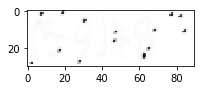

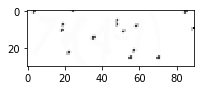

In [151]:
predict_ensemble(best_models)

0.999964408505 0.999750859535 5 5 [5508, 1692, 11294, 5782, 8967]
pred:(2-7)-9 label:(2*7)-9
pred:(5-9)+8 label:(5-9)*8
pred:7+(4-0) label:7+(4-7)
pred:5+1*5NN label:5*1*5NN
pred:2*(9+9) label:2*(9+3)
pred:(2-7)-9 label:(2*7)-9
pred:(5-9)+8 label:(5-9)*8
pred:7+(4-0) label:7+(4-7)
pred:5+1*5NN label:5*1*5NN
pred:2*(9+9) label:2*(9+3)


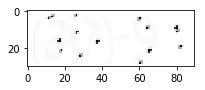

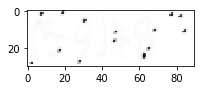

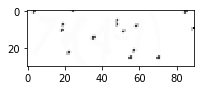

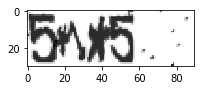

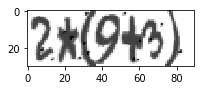

In [150]:
predict_ensemble(best_2_models)

20032/20069 [============================>.] - ETA: 0s0.999935935309 0.999551547162 9 9 [13415, 7051, 1810, 5782, 4664, 19449, 14279, 11294, 18751]
pred:5-(6*6) label:5-(6*1)
pred:9-1*5NN label:9-1+5NN
pred:9*1-4NN label:9+1-4NN
pred:5+1*5NN label:5*1*5NN
pred:4+4-1NN label:4+4-0NN
pred:9+8-4NN label:9+9-4NN
pred:(2*3)*9 label:(2*3)+9
pred:7+(4-8) label:7+(4-7)
pred:6+(0+6) label:6+(1+6)


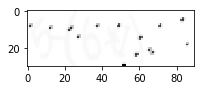

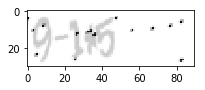

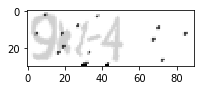

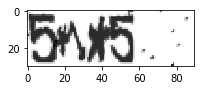

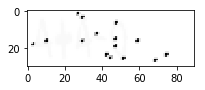

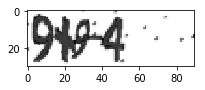

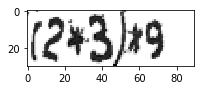

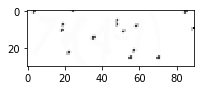

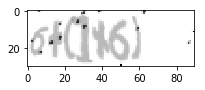

In [154]:
predict_single(model)

In [1]:
model = get_model()
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(trn_batches, len(x_trn), nb_epoch=1, validation_data=(x_val, y_val))

model.optimizer.lr=0.1
model.fit_generator(trn_batches, len(x_trn), nb_epoch=4, validation_data=(x_val, y_val))

model.optimizer.lr=0.01
model.fit_generator(trn_batches, len(x_trn), nb_epoch=12, validation_data=(x_val, y_val))

model.optimizer.lr=0.001
model.fit_generator(trn_batches, len(x_trn), nb_epoch=12, validation_data=(x_val, y_val))

model.optimizer.lr=0.0001
model.fit_generator(trn_batches, len(x_trn), nb_epoch=10, validation_data=(x_val, y_val))

NameError: name 'get_model' is not defined

In [6]:
final_models = []
for i in range(6):
    m = get_model()
    m.load_weights('best_2.wgt'+str(i))
    final_models.append(m)

In [ ]:
exps = []
test_val = test_imgs
all_preds=[]
avg_preds=[]
for i in xrange(0, len(test_val), 1000):
    if i%10000==0:
        print(i/10000)
    ridx = i + 1000
    if ridx > len(test_val):
        ridx = len(test_val)
    all_preds = np.stack([m.predict(test_val[i:ridx], batch_size=256) for m in final_models])
    avg_preds = all_preds.mean(axis=0)
    preds = np.array([[np.argmax(i) for i in p] for p in avg_preds])
    for idx in range(len(preds)):
        exp = ''.join([tokens[i].rstrip('N') for i in preds[idx]]) 
        r=0
        try:
            r=eval(exp)
        except SyntaxError:
            print(str(len(exps)) +'|'+ exp)
            #plot(test_val[len(exps)].reshape((30,90)))
        exps.append(exp+' '+str(r))


0.0
1.0
17416|7*(+)
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
95303|(+++)
10.0
102187|(+(*))
11.0


In [9]:
exps[:20]

['1-1*4-3',
 '(1-8)*4-28',
 '1+(8*5)41',
 '7+0*97',
 '(8-1)-8-1',
 '(6+7)-67',
 '(4+3)-70',
 '(5*1)+05',
 '8+7*08',
 '2*9-117',
 '0+5+05',
 '(5-6)+21',
 '(1+7)*00',
 '3+3-7-1',
 '1+(4+6)11',
 '7+8*223',
 '7-3*6-11',
 '9-(7-4)6',
 '(7*0)+00',
 '5-2-8-5']

In [ ]:
with open('somefile.txt', 'a') as the_file:
    the_file.write('Hello\n')
    

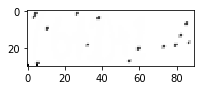

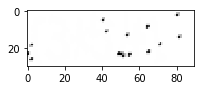

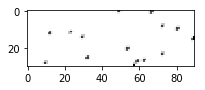

In [22]:
##17416.png，95303.png，142660.png
for img in test_val: 
    plot(img.reshape(30,90))

In [23]:
exps

['7*(+)', '(+++)', '(*(5)']

In [27]:
try:
    eval("1 + 2) + 3")
except SyntaxError:
    print('(+++)')

(+++)


In [8]:
test_imgs[102187].reshape((30,90)).shape

(30, 90)

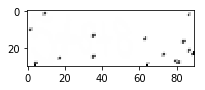

In [10]:
plot(test_imgs[102187].reshape((30,90)))